In [ ]:
import os
from pathlib import Path

# Print the current working directory
starting_path = os.getcwd()

# Change directory to sleap-roots
if os.path.basename(os.getcwd()) == "sleap-roots":
    pass
else:
    os.chdir("..")
    
current_path = os.getcwd()

print(f"Starting directory: {starting_path}")
print(f"Changed to directory: {current_path}")

import pandas as pd
import numpy as np

import sleap_roots as sr
import sleap_io as sio

from sleap_roots.series import *
from sleap_roots.trait_pipelines import *
from sleap_roots.points import *
from sleap_roots.angle import *
from sleap_roots.scanline import *
from sleap_roots.bases import *
from sleap_roots.tips import *

Starting directory: /Users/andrewoconnor/Projects/sleap-roots/notebooks
Changed to directory: /Users/andrewoconnor/Projects/sleap-roots


### Load canola data `919QDUH`

- Frame 67 has a single primary root.
- Due to discontinuity in the root, `get_primary_points` will return an array of (2, nodes, 2), implying that there are 2 primary root instances
- How should this be handled?

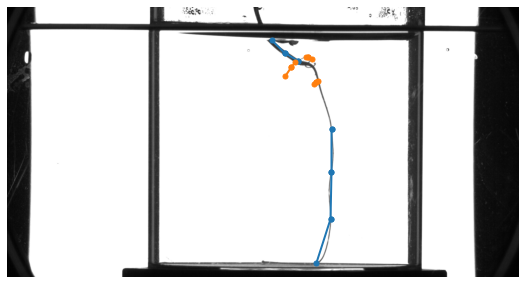

In [4]:
folder_path = "tests/data/canola_7do"
all_slps = sr.find_all_slp_paths(folder_path)

series = sr.load_series_from_slps(all_slps, h5s=True)[0]
series.plot(67, scale=0.25)

In [10]:
# Load the primary points for slide 67, plotted above.
primary_pts = series.get_primary_points(67)

print(primary_pts.shape)
primary_pts

(2, 6, 2)


array([[[1056.83361816,  132.4859314 ],
        [1108.94604492,  184.06916809],
        [1164.67492676,  216.75842285],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan]],

       [[          nan,           nan],
        [          nan,           nan],
        [1296.75146484,  488.30648804],
        [1296.68811035,  660.53668213],
        [1292.8458252 ,  848.39971924],
        [1236.2376709 , 1024.48925781]]])

### The `DicotPipeline` handles this case by converting `primary_pts` to `primary_max_length_points`
- In the case above with a discontinuous primary root, primary_pts are passed into the function `get_max_length_pts`
- The function will choose the longer segment of the primary root, ignoring the other segment.

In [11]:
primary_max_length_pts = get_max_length_pts(primary_pts)
primary_max_length_pts

array([[          nan,           nan],
       [          nan,           nan],
       [1296.75146484,  488.30648804],
       [1296.68811035,  660.53668213],
       [1292.8458252 ,  848.39971924],
       [1236.2376709 , 1024.48925781]])

Pros:
- Simple solution to implement.

Cons:
- Underestimates the true length of the primary root.

Asides:
- May not be a big issue since there are other frames that can capture the true primary root length. This would mostly affect some summary statistics (min primary root length, brings down the mean/median primary root length)

### Another option could be to flatten the primary root instance using `get_all_points_array`
- Flattens the (nodes, instances, 2) array into (nodes, 2)

<br>

Pros
- Preserves the true structure/length of the primary root.

Cons
- For images with multiple primary roots, it will concatenate all root points into 1 array. This is not good.
- For example, if plate data has labels all on the same image and a plate truly has 5 distinct primary roots, this cannot work

In [13]:
primary_pts_lst = get_all_pts_array(primary_pts)

print(primary_pts_lst.shape)
primary_pts_lst

(12, 2)


array([[1056.83361816,  132.4859314 ],
       [1108.94604492,  184.06916809],
       [1164.67492676,  216.75842285],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [1296.75146484,  488.30648804],
       [1296.68811035,  660.53668213],
       [1292.8458252 ,  848.39971924],
       [1236.2376709 , 1024.48925781]])

### Decision: PrimaryRootPipeline will process primary points using `get_max_length_pts`